

#**DATA 690 Finance Data Science Midterm Project**
  - Spring 2022
  - Lee Whieldon
  - Sean Reidy



## Mounting Drive & Import Libraries

In [ ]:
# Mounting our shared drive to save datasets used in project
from google.colab import drive 
drive.mount('/content/drive',force_remount=True)

import os 

os.chdir("/content/drive/MyDrive/Financial_Data_Science_Project_Spring22/Project Datasets")

Mounted at /content/drive


In [ ]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 6.4 MB 63.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import requests
import yfinance as yf

# <b>Portfolio Optimization</b>

<p align="left">
<img src="https://us.simplerousercontent.net/uploads/asset/file/4408990/individual_stocks.jpg" height=400/>
</p>

## **Overview & Background**

Do <b>ETFs (Exchange Traded Funds)</b> traded on <b>NASDAQ</b> & <b>NYSE</b> provide a more *optimized & diversified* portfolio based on month end returns when compared to individual stocks traded on NASDAQ & NYSE during moments of market disruption?

What do we mean by <b>market disruption</b>? We consider them to be any situation where the market ceases to function in a normal manner, including physical disruptions (i.e. natural disasters) or market crashes [1].

What are <b>ETFs</b>? An ETF is a collection or "basket" of individual stocks, bonds, or other investments, all pooled together into a single asset type. When a person elects to invest in a share of an ETF, they will own a fraction of that pool of investments [2].

In this project, we will take a look at the following market disruption date durations, comparing the ETFs versus individual stocks within these periods to determine if a collection of solely ETFs provide a more optimized portfolio over a collection of solely stocks during periods of disruption:

- <b>2015–16 Stock Market Selloff</b>: 6/1/2015 - 6/30/2016 [3].
- <b>Subprime loan/Financial Crisis</b>: 12/27/2007 -  6/30/2009 (Based on when unemployment rate peaked) [4].
- <b>COVID Pandemic</b>: 2/20/2020-2/1/2022 (we elected to end our COVID period 2/1/2022 to ensure we have a true month close figure for our analysis) [5].

We will determine the ETFs & indivdual stocks to review for portfolio optimization within the exploratory data analysis section, pulling the top 200 stocks for our analysis. We then apply **Markowitz Portfolio Theory** to understand the most optimal & diversified portfolio of ETFs versus Stocks using a Monte Carlo simulation and Sharpe Ratio. Lastly, we wrap up with Hypothesis testing, our conclusions & future study takeaways.

#  **Data Collection & Preparation**

In this section, we work to collect data from the following sources to help us answer our project topic:

- `AlphaVantage`: API endpoint classified stocks & ETFs into separate Asset Types for which we will use to compare in our analysis.
- `Polygon.io API`: Provide real time & historical data for US Stocks, used in our assignment to determine top 200 ETFs & Stocks during the moments of market disruptions included in this study.
- `yfinance`: Pull daily data for each stock and ETF to allow us to more easily infer portfolio optimization in the project. 

## Selecting the dates in scope for assignment

Creating simple dataframes we can evoke when needing to review specific date durations included in our assignment.

In [ ]:
# Stock Market Selloff: Series of global sell-offs that took place over an approximately one-year time frame
market_selloff_period = pd.DataFrame({'date':pd.date_range(start='6/1/2005', end='6/30/2006',freq='M')})

# Subprime Period ended 6/30/2009 based on when unemployment rate peaked
subprime_period = pd.DataFrame({'date':pd.date_range(start='12/27/2007', end='6/30/2009',freq='M')})

#COVID
covid_period = pd.DataFrame({'date':pd.date_range(start='2/20/2020', end='2/1/2022',freq='M')})


## AlphaVantage Asset Types

AlphaVantage API endpoint returns a list of all active and delisted (inactive) stocks and ETFs. In our analysis, this API endpoint is used to gather a list of all active & delisted stocks on month end 1/31/2022 (note this is the last month end value in our analysis time period), then extracting only ETFs & Stocks traded on NASDAQ & NYSE.

***Note:*** Alpha Vantage maintains asset information information from 1/1/2010 to date so our analysis is limited to the stock/ETF selection tracked from AlphaVantage, but this should still give us a comprehensive list of stocks & ETFs to answer our project problem.




In [ ]:
# I grabbed a free api key using my umbc email
api_key = 'A7SG8Y27VZIVHCYR'

In [ ]:
# Pull list of active stocks as of last day of our analysis, 1/31/2022
active_stock_group = []
active_stocks = "https://www.alphavantage.co/query?function=LISTING_STATUS&date=2022-01-31&state=active&apikey="+api_key
with requests.Session() as s:
    download = s.get(active_stocks)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)
    active_stocks = pd.DataFrame(my_list[1::],columns=my_list[0])

In [ ]:
# Pull list of delisted (inactive) stocks as of last day of our analysis, 1/31/2022
delisted_stock_group = []
delisted_stocks = "https://www.alphavantage.co/query?function=LISTING_STATUS&date=2022-01-31&state=delisted&apikey="+api_key
with requests.Session() as s:
    download = s.get(delisted_stocks)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)
    delisted_stocks = pd.DataFrame(my_list[1::],columns=my_list[0])

In [ ]:
# Combine into active & delisted values into single dataframe, filter to only stocks tranded on NYSE & NASDAQ

all_stocks = pd.concat([active_stocks,delisted_stocks],ignore_index=True,sort=False)
nyse_stocks= all_stocks[all_stocks['exchange']=='NYSE']
nasdaq_stocks = all_stocks[all_stocks['exchange']=='NASDAQ']
clean_stocks = pd.concat([nyse_stocks,nasdaq_stocks])
clean_stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14075 entries, 0 to 17770
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   symbol         14075 non-null  object
 1   name           14075 non-null  object
 2   exchange       14075 non-null  object
 3   assetType      14075 non-null  object
 4   ipoDate        14075 non-null  object
 5   delistingDate  14075 non-null  object
 6   status         14075 non-null  object
dtypes: object(7)
memory usage: 879.7+ KB


## Polygon.io API

`Polygon.io API` (https://polygon.io/stocks) provides real time & historical data for US stocks. We've elected to use stock data from this API instead, given it's ease of use in exporting data (Google, Robinhood, & Motley Fool use the data so it seems to be a legitimate source)

I will be using the `Grouped Daily (Bars) GET method` (https://polygon.io/docs/stocks/get_v2_aggs_grouped_locale_us_market_stocks__date) to pull stocks on a daily, adjusted close basis:

The below provides data definitions of the return API `json array`:

- `T` (string): The exchange symbol that this item is traded under.
- `c` (number): The close price for the symbol in the given time period.
- `h` (number): The highest price for the symbol in the given time period.
- `l` (number): The lowest price for the symbol in the given time period.
- `n` (number): The number of transactions in the aggregate window.
- `o` (number): The open price for the symbol in the given time period.
- `t` (integer): The Unix Msec timestamp for the start of the aggregate window.
- `v` (number): The trading volume of the symbol in the given time period.
- `vw` (number): The volume weighted average price.


In [ ]:
api_key = 'vGuDeZa8KnwA0vW6IJzMa8lhSVTD8hE7' #Paid API key, will become deactivated on April 20th, 2022 after project is submitted. :)

In [ ]:
# Subprime Period ended 6/30/2009 based on when unemployment rate peaked
subprime_data = []
for date in subprime_period['date']:
    grouped_daily_stocks = requests.get('https://api.polygon.io/v2/aggs/grouped/locale/us/market/stocks/'+date.strftime("%Y-%m-%d")+'?adjusted=true&apiKey='+api_key)
    jsonResponse = grouped_daily_stocks.json()
    if len(jsonResponse) == 7:     
      stocks = pd.json_normalize(jsonResponse["results"]) 
      stocks['date'] = date.strftime("%Y-%m-%d")
      stocks['disruptionName'] = 'Subprime Loan Crisis'
      subprime_data.append(stocks)
subprime_data = pd.concat(subprime_data)  

In [ ]:
# Stock Market Selloff: Series of global sell-offs that took place over an approximately one-year time frame
market_selloff_data = []
for date in market_selloff_period['date']:
    grouped_daily_stocks = requests.get('https://api.polygon.io/v2/aggs/grouped/locale/us/market/stocks/'+date.strftime("%Y-%m-%d")+'?adjusted=true&apiKey='+api_key)
    jsonResponse = grouped_daily_stocks.json()
    if len(jsonResponse) == 7:     
      stocks = pd.json_normalize(jsonResponse["results"]) 
      stocks['date'] = date.strftime("%Y-%m-%d")
      stocks['disruptionName'] = '2005 Stock Market Selloff'
      market_selloff_data.append(stocks)
market_selloff_data = pd.concat(market_selloff_data)  

In [ ]:
# COVID
covid_data = []
for date in covid_period['date']:
    grouped_daily_stocks = requests.get('https://api.polygon.io/v2/aggs/grouped/locale/us/market/stocks/'+date.strftime("%Y-%m-%d")+'?adjusted=true&apiKey='+api_key)
    jsonResponse = grouped_daily_stocks.json()
    if len(jsonResponse) == 7:     
      stocks = pd.json_normalize(jsonResponse["results"]) 
      stocks['date'] = date.strftime("%Y-%m-%d")
      stocks['disruptionName'] = 'COVID Pandemic'
      covid_data.append(stocks)
covid_data = pd.concat(covid_data)  

In [ ]:
# Join all data together into a single dataframe
market_data = pd.concat([market_selloff_data,subprime_data,covid_data],ignore_index=True,sort=False)

In [ ]:
# Rename columns to provide more context
market_data = market_data.rename(columns = {'T': 'symbol','c':'closePrice','h':'highestPrice','l':'lowestPrice','n':'totalTransactions','o':'openPrice','t':'unixTimestamp','v':'tradingVolume','vw':'volumeWeightedAvgPrice'})

In [ ]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336006 entries, 0 to 336005
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   symbol                  336006 non-null  object 
 1   tradingVolume           336006 non-null  float64
 2   volumeWeightedAvgPrice  335445 non-null  float64
 3   openPrice               336006 non-null  float64
 4   closePrice              336006 non-null  float64
 5   highestPrice            336006 non-null  float64
 6   lowestPrice             336006 non-null  float64
 7   unixTimestamp           336006 non-null  int64  
 8   totalTransactions       335445 non-null  float64
 9   date                    336006 non-null  object 
 10  disruptionName          336006 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 28.2+ MB


In [ ]:
# Update datatypes
market_data['date'] = pd.to_datetime(market_data['date'])

In [ ]:
# join data together to narrow down only NYSE/NASDAQ active & delisted stocks in question & save to pickle
stock_data = pd.merge(market_data,clean_stocks, on='symbol')
stock_data.to_pickle('complete_historical_market_asset_type_data.pickle')
print(stock_data.info())
stock_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196721 entries, 0 to 196720
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   symbol                  196721 non-null  object        
 1   tradingVolume           196721 non-null  float64       
 2   volumeWeightedAvgPrice  196718 non-null  float64       
 3   openPrice               196721 non-null  float64       
 4   closePrice              196721 non-null  float64       
 5   highestPrice            196721 non-null  float64       
 6   lowestPrice             196721 non-null  float64       
 7   unixTimestamp           196721 non-null  int64         
 8   totalTransactions       196718 non-null  float64       
 9   date                    196721 non-null  datetime64[ns]
 10  disruptionName          196721 non-null  object        
 11  name                    196721 non-null  object        
 12  exchange                196721

,symbol,tradingVolume,volumeWeightedAvgPrice,openPrice,closePrice,highestPrice,lowestPrice,unixTimestamp,totalTransactions,date,disruptionName,name,exchange,assetType,ipoDate,delistingDate,status
0,RBNC,379921.0,14.9513,15.00,14.97,15.00,14.75,1120161600000,1241.0,2005-06-30,2005 Stock Market Selloff,Reliant Bancorp Inc,NASDAQ,Stock,2018-01-02,2021-12-31,Delisted
1,RBNC,201300.0,14.5417,14.61,14.68,14.68,14.30,1125518400000,759.0,2005-08-31,2005 Stock Market Selloff,Reliant Bancorp Inc,NASDAQ,Stock,2018-01-02,2021-12-31,Delisted
2,RBNC,269267.0,14.1278,14.23,14.14,14.23,14.05,1128110400000,1272.0,2005-09-30,2005 Stock Market Selloff,Reliant Bancorp Inc,NASDAQ,Stock,2018-01-02,2021-12-31,Delisted
3,RBNC,575557.0,13.7344,13.76,13.65,13.89,13.64,1130792400000,1877.0,2005-10-31,2005 Stock Market Selloff,Reliant Bancorp Inc,NASDAQ,Stock,2018-01-02,2021-12-31,Delisted
4,RBNC,361103.0,12.4213,12.50,12.42,12.60,12.32,1133384400000,1857.0,2005-11-30,2005 Stock Market Selloff,Reliant Bancorp Inc,NASDAQ,Stock,2018-01-02,2021-12-31,Delisted


## Yfinance

Using a combination of data from both Alpha Vantage and Polygon.io, we generate a list of the most popular stocks and ETFs for each of the three market disruptions.  Then we use the list of symbols to pull daily data for each stock and ETF from yFinance that will allow us to more easily infer portfolio optimization in following sections. 

In [ ]:
#Run This Cell If you need to pull data from pickle file again
# Pulling Stock Data from pickle file 
raw_df = pd.read_pickle('complete_historical_market_asset_type_data.pickle')

In [ ]:
#Split the Dataset into two dataframe one for Stocks and one for ETFs
#Stock Dataset 
stock_df = raw_df.loc[raw_df['assetType'] == 'Stock']

#ETF Dataset 
etf_df = raw_df.loc[raw_df['assetType'] == 'ETF']

In [ ]:
#Determining the "most popular" Stocks and ETFs, by ranking them by mean trading
#Volume, grouped by each of the three market disruptions 

#Piviot Table of means for continuious vars
mean_stock = stock_df.groupby(['symbol','disruptionName']).mean()
mean_etf = etf_df.groupby(['symbol','disruptionName']).mean() 

#Sort the tables by trading Volume
mean_stock = mean_stock.sort_values('tradingVolume', ascending=False)
mean_etf = mean_etf.sort_values('tradingVolume', ascending=False)

In [ ]:
#Extract Top 20 number of Stocks and ETF by Trading Volume for each disruptionName

n = 20
#Break each disruption into a temp dataframe
COVID_subset_stock = mean_stock[np.in1d(mean_stock.index.get_level_values(1), ['COVID Pandemic'])]
Subprime_subset_stock = mean_stock[np.in1d(mean_stock.index.get_level_values(1), ['Subprime Loan Crisis'])] 
selloff_subset_stock = mean_stock[np.in1d(mean_stock.index.get_level_values(1), ['2005 Stock Market Selloff'])] 


COVID_subset_etf = mean_etf[np.in1d(mean_etf.index.get_level_values(1), ['COVID Pandemic'])]
Subprime_subset_etf = mean_etf[np.in1d(mean_etf.index.get_level_values(1), ['Subprime Loan Crisis'])] 
selloff_subset_etf = mean_etf[np.in1d(mean_etf.index.get_level_values(1), ['2005 Stock Market Selloff'])] 


# Select only the n highest by tradingVolume
COVID_subset_stock= COVID_subset_stock.nlargest(n,'tradingVolume')
Subprime_subset_stock = Subprime_subset_stock.nlargest(n,'tradingVolume')
selloff_subset_stock = selloff_subset_stock.nlargest(n,'tradingVolume')

COVID_subset_etf= COVID_subset_etf.nlargest(n,'tradingVolume')
Subprime_subset_etf = Subprime_subset_etf.nlargest(n,'tradingVolume')
selloff_subset_etf = selloff_subset_etf.nlargest(n,'tradingVolume')

#remove disruption grouping index 
COVID_subset_stock = COVID_subset_stock.reset_index(level=1)
Subprime_subset_stock = Subprime_subset_stock.reset_index(level=1)
selloff_subset_stock = selloff_subset_stock.reset_index(level=1)

COVID_subset_etf = COVID_subset_etf.reset_index(level=1)
Subprime_subset_etf = Subprime_subset_etf.reset_index(level=1)
selloff_subset_etf = selloff_subset_etf.reset_index(level=1)

#Get List of top n stocks and ETF for each Disruption 
topStockSymbolsCOVID = list(COVID_subset_stock.index.values)
topStockSymbolsSubprime = list(Subprime_subset_stock.index.values)
topStockSymbolsSelloff = list(selloff_subset_stock.index.values)

topEtfSymbolsCOVID = list(COVID_subset_etf.index.values)
topEtfSymbolsSubprime = list(Subprime_subset_etf.index.values)
topEtfSymbolsSelloff = list(selloff_subset_etf.index.values)

#print the top 5 Stocks and top 5 ETFs during the COVID time peroud 
print("Top Stocks (COVID): ", topStockSymbolsCOVID[0:5])
print("Top ETF (COVID): " , topEtfSymbolsCOVID[0:5])

Top Stocks (COVID):  ['SNDL', 'AAPL', 'FAMI', 'NIO', 'F']
Top ETF (COVID):  ['TQQQ', 'QQQ', 'SQQQ', 'TLT', 'BND']


In [ ]:
#Make a list of the Stocks and ETFs that were in the top 20 most popular for every
#market disruption period 

topStockAllDisruption = list(set(topStockSymbolsCOVID).intersection(topStockSymbolsSubprime,topStockSymbolsSelloff))
topEtfAllDisruption = list(set(topEtfSymbolsCOVID).intersection(topEtfSymbolsSubprime,topEtfSymbolsSelloff))

#print the top for each 
print("Top Stocks found in all disruptions: " , topStockAllDisruption)
print("Top ETFs found in all disruptions: ", topEtfAllDisruption)

Top Stocks found in all disruptions:  ['AAPL']
Top ETFs found in all disruptions:  ['SMH', 'TLT']


In [ ]:
#Using the List of top Stocks and ETFs from our data, we can now 
#Pull daily data from yfinance, allowing us more detailied analisis on returns and 
#risk 

# The Three Disruptions (COVID, Subprime, Selloff)
covid_start = datetime.datetime(2020,2,20)
covid_end = datetime.datetime(2022,2,1)

subprime_start = datetime.datetime(2007,12,27)
subprime_end = datetime.datetime(2009,6,30)

selloff_start = datetime.datetime(2015,6,1)
selloff_end = datetime.datetime(2016,6,30)


#Pull Data
ETFs_covid = yf.download(topEtfSymbolsCOVID,start=covid_start,end = covid_end, interval='1d',progress=False) 
stocks_covid = yf.download(topStockSymbolsCOVID,start=covid_start,end = covid_end, interval='1d',progress=False)

ETFs_subprime = yf.download(topEtfSymbolsSubprime,start=subprime_start,end=subprime_end, interval ='1d',progress=False)
stocks_subprime = yf.download(topStockSymbolsSubprime,start=subprime_start,end=subprime_end, interval ='1d',progress=False)

ETFs_selloff = yf.download(topEtfSymbolsSelloff,start=selloff_start,end=selloff_end,interval = '1d',progress=False)
stocks_selloff = yf.download(topStockSymbolsSelloff,start=selloff_start,end=selloff_end,interval = '1d',progress=False)


*Note:* Some of the yfinance downloads fail either because they are delisted before the specified endDate

In [ ]:
# Calculations 

# Calcualtions: mean closing price and mean returns 
ETFs_covid['meanClose'] = ETFs_covid['Close'].mean(axis = 1)
stocks_covid['meanClose'] = stocks_covid['Close'].mean(axis = 1)

ETFs_subprime['meanClose'] = ETFs_subprime['Close'].mean(axis = 1)
stocks_subprime['meanClose'] = stocks_subprime['Close'].mean(axis = 1)

ETFs_selloff['meanClose'] = ETFs_selloff['Close'].mean(axis = 1)
stocks_selloff['meanClose'] = stocks_selloff['Close'].mean(axis = 1)


In [ ]:
#Save Data to Picke as backup 
os.chdir("/content/drive/MyDrive/Financial_Data_Science_Project_Spring22/Project Datasets")
def saveALL():
  ETFs_covid.to_pickle('ETFs_covid.pkl')
  stocks_covid.to_pickle('stocks_covid.pkl')
  ETFs_subprime.to_pickle('ETFs_subprime.pkl')
  stocks_subprime.to_pickle('stocks_subprime.pkl')
  ETFs_selloff.to_pickle('ETFs_selloff.pkl')
  stocks_selloff.to_pickle('stocks_selloff.pkl')

saveALL()

# **Exploratory Data Analysis & General Observations**

Whenever working with time series data, visualization is the most effective tool for analyzing trends and patterns in the data.  After gathering data on the top performing stocks and ETFs, ranked by average trading volume, we will look at the closing prices and returns of both. First we plot the top 10 stocks and ETFs for each of the three disruption periods (COVID, Selloff, and Subprime Crisis).

### Load Cached Data 

In [ ]:
# Load Cashed data
ETFs_covid = pd.read_pickle('ETFs_covid.pkl')
stocks_covid = pd.read_pickle('stocks_covid.pkl')
ETFs_subprime = pd.read_pickle('ETFs_subprime.pkl')
stocks_subprime = pd.read_pickle('stocks_subprime.pkl')
ETFs_selloff = pd.read_pickle('ETFs_selloff.pkl')
stocks_selloff = pd.read_pickle('stocks_selloff.pkl')

##Time Series Plots

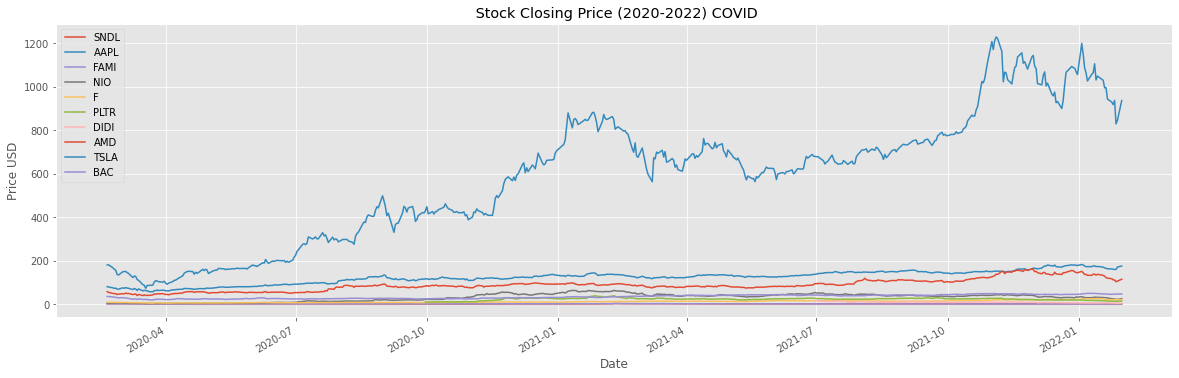

In [ ]:
# Top Stocks During COVID
plt.style.use('ggplot')
temp_df = stocks_covid['Close']
temp_df.plot(y = topStockSymbolsCOVID[:10], figsize = (20,6))
plt.title(' Stock Closing Price (2020-2022) COVID')
plt.ylabel('Price USD')
plt.xlabel('Date')
plt.show()

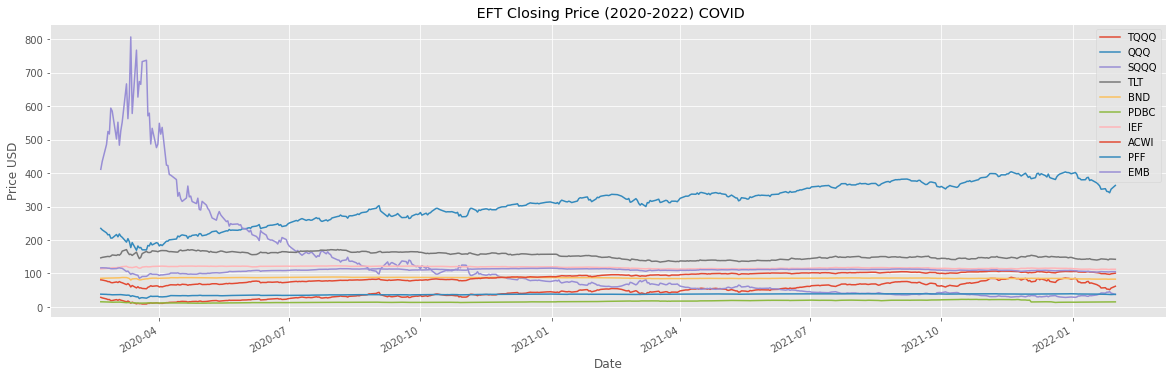

In [ ]:
#plt.figure(figsize = (20,6))
temp_df = ETFs_covid['Close']
temp_df.plot(y = topEtfSymbolsCOVID[:10] , figsize = (20,6))
plt.title(' EFT Closing Price (2020-2022) COVID')
plt.ylabel('Price USD')
plt.xlabel('Date')
plt.show()

We are interesting in measuring the performance of Stocks Vs. ETFs during different periods of distributions. Therefore visualizing the mean prices of all top traded assets during the time periods can provide a high level view of the differences between the assets classes. 

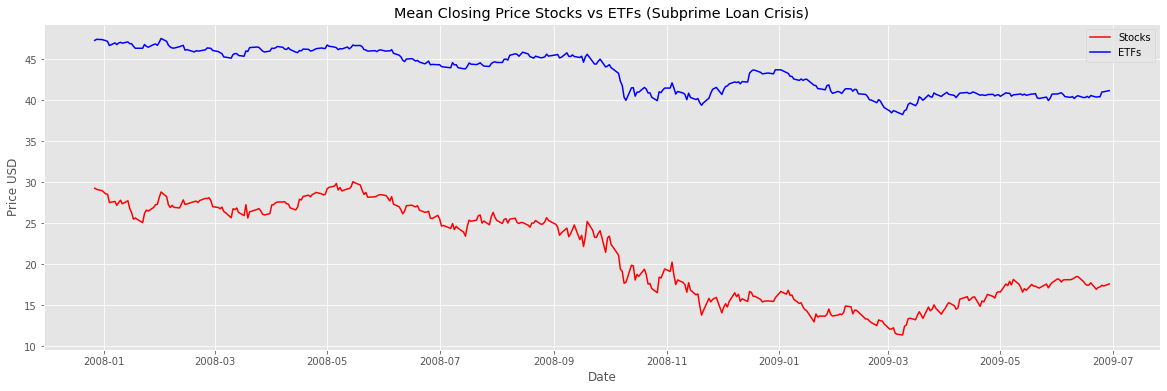

In [ ]:
fig = plt.figure(figsize=(20,6))
ax3 = fig.add_subplot(111)

ax3.plot(stocks_subprime['meanClose'], color = 'red', label = 'Stocks')
ax3.plot(ETFs_subprime['meanClose'], color = 'blue', label = 'ETFs')
plt.title('Mean Closing Price Stocks vs ETFs (Subprime Loan Crisis)')
plt.ylabel('Price USD')
plt.xlabel('Date')
ax3.legend()

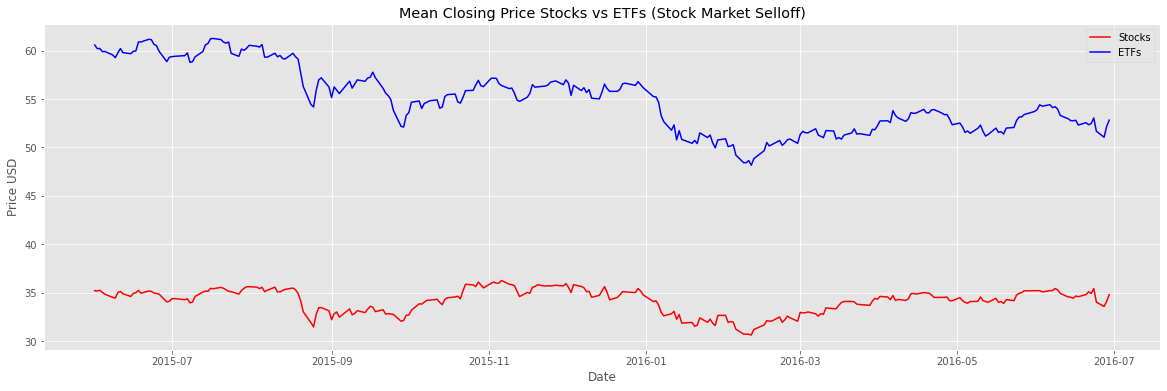

In [ ]:
fig = plt.figure(figsize=(20,6))
ax2 = fig.add_subplot(111)

ax2.plot(stocks_selloff['meanClose'], color = 'red', label = 'Stocks')
ax2.plot(ETFs_selloff['meanClose'], color = 'blue', label = 'ETFs')
plt.title('Mean Closing Price Stocks vs ETFs (Stock Market Selloff)')
plt.ylabel('Price USD')
plt.xlabel('Date')
ax2.legend()

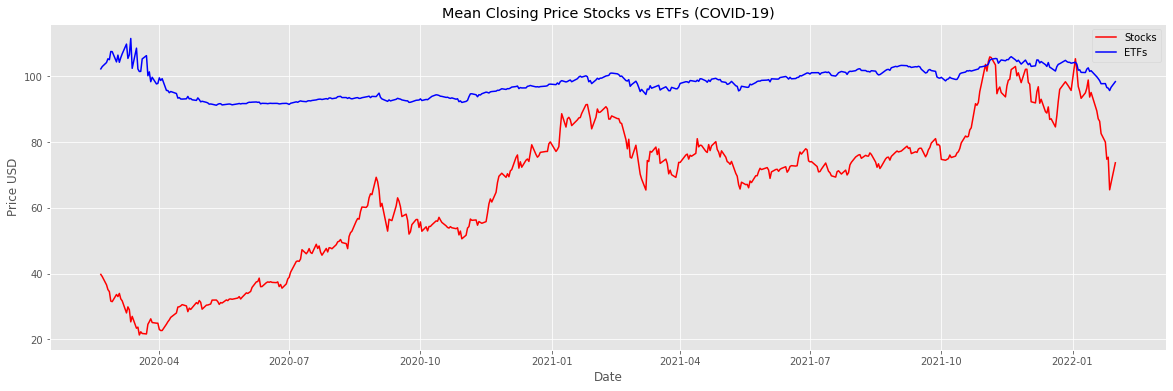

In [ ]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(111)

ax1.plot(stocks_covid['meanClose'], color = 'red', label = 'Stocks')
ax1.plot(ETFs_covid['meanClose'], color = 'blue', label = 'ETFs')
plt.title('Mean Closing Price Stocks vs ETFs (COVID-19)')
plt.ylabel('Price USD')
plt.xlabel('Date')
ax1.legend()


Visually inspecting the closing prices of both stocks and ETFs over all three disruption periods, we can see that ETFs have a **higher mean price** when compared to stocks. Additionally ETFs appear **far less volatile, and more resistant to sudden drops and climbs in the market**. 

In a minor to moderate situation, ETFs outperform individual stocks; when the market expense rapidly changes, ETFs  advantages are less evident. Expanding upon this, **the situational context of the disruption event influences the difference between stocks and ETFs**. For example, during the COVID-19 pandemic, some industry segments were subject to greater losses (hospitality, travel, etc.) and other saw rapid growth (online service, biotech). 

When market disruptions are evenly felt across every market, such as the subprime loan crisis, **ETF’s appear to lose their advantages**. We will investigate this further by looking at the returns. 

# **Portfolio Optimization & Diversification Review**

As described in UMBC's <b>Spring 2022 DATA690: Data Science in Finance</b> course created by [Dr. Abdullah Karasan](https://www.linkedin.com/in/abdullahkarasan/), "the main purpose of portfolio formation is to allocate funds to different financial assets and to try to minimize the risk through *diversification & optimization*. Porfolio management is a dynamic investment management process that aims to allocate the funds held by the investor to existing financial asset alternatives in such a way to provide the highest return given a certain risk level" [6],[7].

In this section, we explore the following:

- **Calculate the returns** and visually review the distribution of the returns across the asset types & market disruption periods.
- Then, we take the top 20 ETFs and Stocks to decide if a collection of ETFs versus Stocks will provide a more **optimized portfolio**. 
- We then infer which assets to withdraw from the portfolio depending on time-varying conditions. To address this problem, we will use <b>Markowitz Portfolio Theory</b>.
- Lastly, we review the **Sharpe Ratio** of each Asset Type across all market disruption periods to see the optimal risk/return combination for each cohort.

As a summary, **Markowitz Portfolio Theory** is excellent to use in our project due to its ability to maximize expected portfolio returns and simultaneous minimzation of investment risk [8].



## Calculate Returns

We use log returns to calculate the mean and variance. First, let us calculate the log returns:

In [ ]:
# Calcluating the Log Returns 
ETFs_covid_returns = np.log(ETFs_covid['Close'] / ETFs_covid['Close'].shift(1))
stocks_covid_returns = np.log(stocks_covid['Close'] / stocks_covid['Close'].shift(1))
ETFs_subprime_returns = np.log(ETFs_subprime['Close'] / ETFs_subprime['Close'].shift(1))
stocks_subprime_returns = np.log(stocks_subprime['Close'] / stocks_subprime['Close'].shift(1))
ETFs_selloff_returns = np.log(ETFs_selloff['Close'] / ETFs_selloff['Close'].shift(1))
stocks_selloff_returns = np.log(stocks_selloff['Close'] / stocks_selloff['Close'].shift(1))


# mean returns price and mean returns 
ETFs_covid_returns['meanReturns'] = ETFs_covid_returns.mean(axis = 1)
stocks_covid_returns['meanReturns'] = stocks_covid_returns.mean(axis = 1)

ETFs_subprime_returns['meanReturns'] = ETFs_subprime_returns.mean(axis = 1)
stocks_subprime_returns['meanReturns'] = stocks_subprime_returns.mean(axis = 1)

ETFs_selloff_returns['meanReturns'] = ETFs_selloff_returns.mean(axis = 1)
stocks_selloff_returns['meanReturns'] = stocks_selloff_returns.mean(axis = 1)

Text(0.5, 1.0, 'COVID-19')

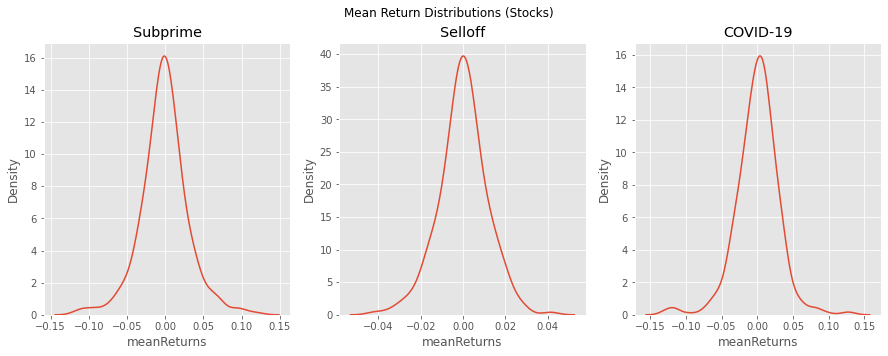

In [ ]:
#EDA for Returns 
# Desnity plots (Stocks)
fig,axs = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('Mean Return Distributions (Stocks)')

#Subprime 
sns.kdeplot(ax = axs[0], data = stocks_subprime_returns['meanReturns'])
axs[0].set_title("Subprime")

#Selloff 
sns.kdeplot(ax = axs[1], data = stocks_selloff_returns['meanReturns'])
axs[1].set_title("Selloff")

#Covid
sns.kdeplot(ax = axs[2], data = stocks_covid_returns['meanReturns'])
axs[2].set_title("COVID-19")

A visual inspection of the distribution of stock return values show that they are approximately  normally distributed. 

Text(0.5, 1.0, 'COVID-19')

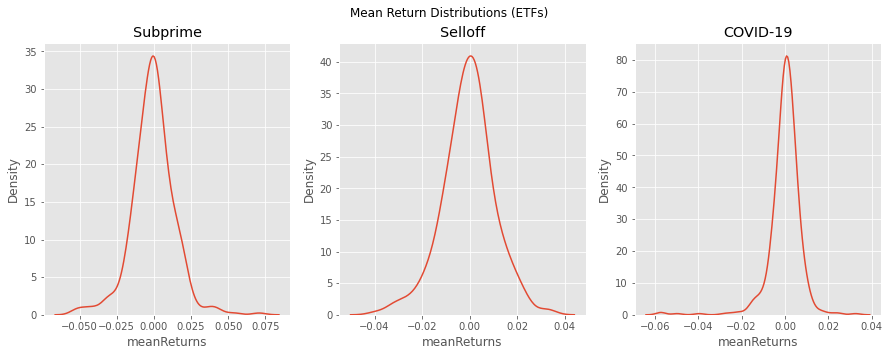

In [ ]:
# Desnity plots (ETFs)
fig,axs = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('Mean Return Distributions (ETFs)')

#Subprime 
sns.kdeplot(ax = axs[0], data = ETFs_subprime_returns['meanReturns'])
axs[0].set_title("Subprime")

#Selloff 
sns.kdeplot(ax = axs[1], data = ETFs_selloff_returns['meanReturns'])
axs[1].set_title("Selloff")

#Covid
sns.kdeplot(ax = axs[2], data = ETFs_covid_returns['meanReturns'])
axs[2].set_title("COVID-19")


Comparatively, ETFs during the Subprime loan criss and the COVID-19 pandemic, show non normally disturbed returns, indicating that their preform differently than the stocks. 

In [ ]:
# Testing For Normality With a Chis-Square Normality Test p >0.05
from scipy.stats import chisquare

def Test_Normality_Returns():
  names = ['Subprime Stock','Subprime ETF','Selloff Stock','Selloff ETF','Covid Stock','Covid ETF']
  data = [stocks_subprime_returns['meanReturns'],ETFs_subprime_returns['meanReturns'],stocks_selloff_returns['meanReturns'],ETFs_selloff_returns['meanReturns'],stocks_covid_returns['meanReturns'],ETFs_covid_returns['meanReturns'] ]
  output = []
  for elem in data: 
    test_stat, p = chisquare(elem.dropna().values)
    #print(test_stat)
    #print(p)
    if p > 0.05: 
      output.append('gaussian')
    else: 
      output.append('not gaussian')
  for i in range(len(names)):
    print(names[i]+ " " + output[i])  
    

Test_Normality_Returns()


Subprime Stock gaussian
Subprime ETF gaussian
Selloff Stock gaussian
Selloff ETF gaussian
Covid Stock not gaussian
Covid ETF gaussian


Running a Chi-Squared Normality test of the distributions of daily mean returns, illustrates that stock returns during the COVID-19 pandemic were not normally distributed, contributing evidence that during this period the negative effects of the pandemic did not uniformly affect the entire market. 

Now let's visualize the mean log returns for all Stocks & ETFS by plotting them visually. Note the two separate lines on each visualization, denoting ETFs & Stocks for each market disruption period.

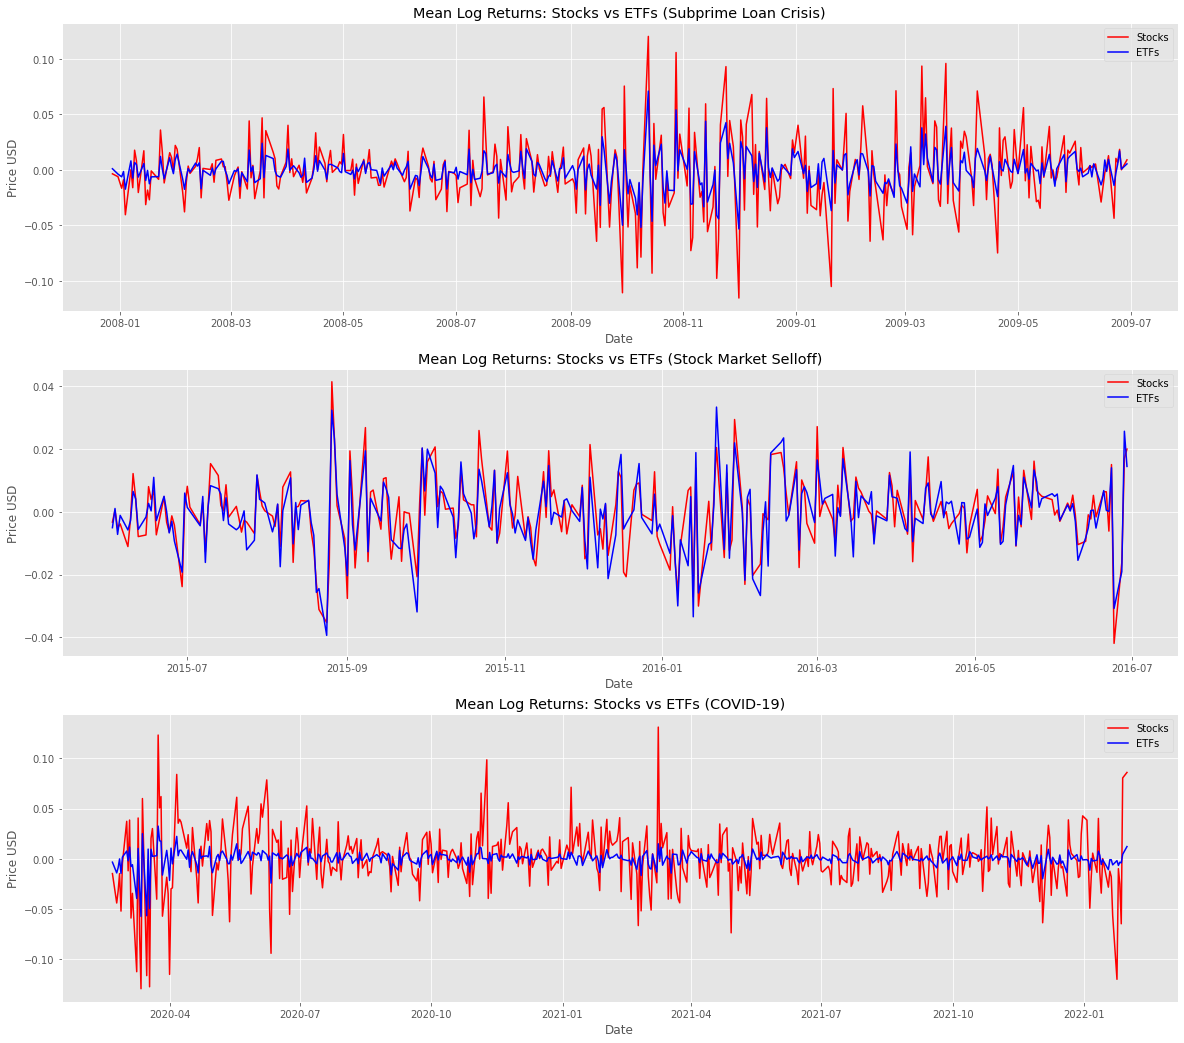

In [ ]:
# Plot Mean Log Returns for each market disruption 
fig, axs = plt.subplots(3,figsize=(20,18))
axs[2].plot(stocks_covid_returns['meanReturns'], color = 'red', label = 'Stocks')
axs[2].plot(ETFs_covid_returns['meanReturns'], color = 'blue', label = 'ETFs')
axs[2].set_title('Mean Log Returns: Stocks vs ETFs (COVID-19)')
axs[2].set_ylabel('Price USD')
axs[2].set_xlabel('Date')
axs[2].legend()
axs[1].plot(stocks_selloff_returns['meanReturns'], color = 'red', label = 'Stocks')
axs[1].plot(ETFs_selloff_returns['meanReturns'], color = 'blue', label = 'ETFs')
axs[1].set_title('Mean Log Returns: Stocks vs ETFs (Stock Market Selloff)')
axs[1].set_ylabel('Price USD')
axs[1].set_xlabel('Date')
axs[1].legend()
axs[0].plot(stocks_subprime_returns['meanReturns'], color = 'red', label = 'Stocks')
axs[0].plot(ETFs_subprime_returns['meanReturns'], color = 'blue', label = 'ETFs')
axs[0].set_title('Mean Log Returns: Stocks vs ETFs (Subprime Loan Crisis)')
axs[0].set_ylabel('Price USD')
axs[0].set_xlabel('Date')
axs[0].legend()


**Key Observations**

 - During COVID-19 ETFs demonstrated a much lower volatility when compared to the other two disruptions. This raises the question if EFTs were managed differently now when compared the other time periods?
 - In general the returns of EFTs follow similar market patterns at a much lower amplitude compared to stocks 
 - There is indication that each of these three events are unique in the resulting effect they had on both stocks and ETFs. 
 - ETFs are able to “weather the storm” of disruption well, at the cost of lower returns, often completely missing out on periods when the market swings up in value. 

## Generate Efficient Frontier: Monte Carlo Simulation

<b>Mean-Variance Portfolio Theory</b> can be used together with <b>Monte Carlo Simulations</b> to estimate the optimum weights for a given portfolio of assets to achieve the 'best' risk-reward trade off. In this section, we generate our efficient frontier using portfolio mean and standard deviation. 

In the interest of a comparison between ETFs and Stocks, we will review top 20 stocks & etfs collected from the 3 disruption periods and see how they performed from the very first disruption period to the end of the last (6/1/2005 to 2/1/2022), using 10,000 iterations to generate multiple stock-return combinations. To do this, we will take advantage of Monte Carlo simulation, allowing us to have larger numbers of expected returns and expected standard deviations. We will repeatedly generate weights and multiple them by mean and covariance matrix.

In [ ]:
iterations=10000
def portfolio_frontier(iterations,stocks,returns):
    portfolio_exp_means = []
    portfolio_std_devs = []
    all_weights = []
    for i in range (iterations):
        weights = np.random.random(len(stocks))
        weights = weights/np.sum(weights)
        all_weights.append(weights)
        portfolio_exp_means.append(np.sum(returns.mean() * weights) * 252) 
        portfolio_std_devs.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov() * np.sqrt(252), weights))))
    return portfolio_exp_means, portfolio_std_devs, all_weights

In [ ]:
def monte_carlo(portfolio_deviation,portfolio_returns,title):
  plt.figure(figsize=(10,6))
  sns.set()
  plt.scatter(portfolio_deviation, portfolio_returns, c=portfolio_returns / portfolio_deviation, marker='o')
  plt.grid(True)
  plt.title('Monte Carlo Simulation of Top Performing '+title)
  plt.xlabel('Expected volatility')
  plt.ylabel('Expected return')
  # plt.show()
  plt.savefig(title+'montecarlo_.png')

In [ ]:
#Top ETFs
topEtfSymbolsCOVID = list(COVID_subset_etf.index.values)
topEtfSymbolsSubprime = list(Subprime_subset_etf.index.values)
topEtfSymbolsSelloff = list(selloff_subset_etf.index.values)

Top_ETFs = topEtfSymbolsCOVID+topEtfSymbolsSubprime+topEtfSymbolsSelloff
Top_ETFs =  list(dict.fromkeys(Top_ETFs))

In [ ]:
# ETF tickers
start = datetime.datetime(2005,6,1)
end = datetime.datetime(2022,2,1)
etf_data = yf.download(Top_ETFs,start=start,end = end, interval='1d',progress=True)['Close']

[*********************100%***********************]  44 of 44 completed

1 Failed download:
- GPM: No data found, symbol may be delisted


In [ ]:
#ETF Returns
ETFs_returns = np.log(etf_data/etf_data.shift(1)).fillna(0)

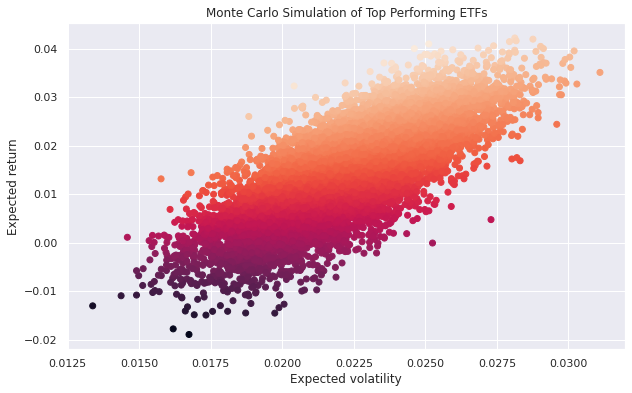

In [ ]:
# ETF Monte Carlo Simulation
portfolio_exp_means_etfs, portfolio_std_devs_etfs, all_weights_etfs = portfolio_frontier(iterations,Top_ETFs,ETFs_returns)
portfolio_returns_etfs = np.array(portfolio_exp_means_etfs)
portfolio_deviation_etfs = np.array(portfolio_std_devs_etfs)
monte_carlo(portfolio_deviation_etfs,portfolio_returns_etfs,'ETFs')

In [ ]:
# Top Stocks
topStockSymbolsCOVID = list(COVID_subset_stock.index.values)
topStockSymbolsSubprime = list(Subprime_subset_stock.index.values)
topStockSymbolsSelloff = list(selloff_subset_stock.index.values)

Top_Stocks = topStockSymbolsCOVID+topStockSymbolsSubprime+topStockSymbolsSelloff
Top_Stocks =  list(dict.fromkeys(Top_Stocks))

In [ ]:
# Stock tickers
start = datetime.datetime(2005,6,1)
end = datetime.datetime(2021,2,1)
stock_data = yf.download(Top_Stocks,start=start,end = end, interval='1d',progress=True)['Close']

[*********************100%***********************]  45 of 45 completed

7 Failed downloads:
- NTRB: Data doesn't exist for startDate = 1117584000, endDate = 1612137600
- LDIS: No data found for this date range, symbol may be delisted
- FGI: Data doesn't exist for startDate = 1117584000, endDate = 1612137600
- JDSU: No data found for this date range, symbol may be delisted
- KSCP: Data doesn't exist for startDate = 1117584000, endDate = 1612137600
- DIDI: Data doesn't exist for startDate = 1117584000, endDate = 1612137600
- TKLF: Data doesn't exist for startDate = 1117584000, endDate = 1612137600


In [ ]:
Stock_returns = np.log(stock_data/stock_data.shift(1)).fillna(0)

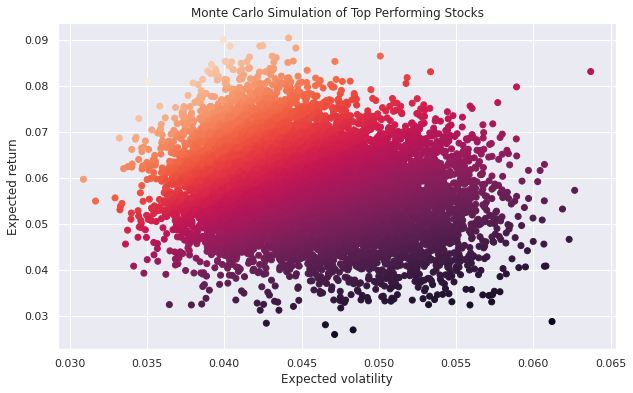

In [ ]:
# Stocks Monte Carlo Simulation
portfolio_exp_means_stocks, portfolio_std_devs_stocks, all_weights_stocks = portfolio_frontier(iterations,Top_Stocks,Stock_returns)
portfolio_returns_stocks = np.array(portfolio_exp_means_stocks)
portfolio_deviation_stocks = np.array(portfolio_std_devs_stocks)
monte_carlo(portfolio_deviation_stocks,portfolio_returns_stocks,'Stocks')

In order to understand the efficient frontier, you can focus on the positively sloped part of the visualizations. Interestingly, I would anticipate more of a boomerang effect but these monte carlo visualizations depict a somewhat slanted behavior. In terms of volatility to return behavior:

- ETFs provide a fairly straightforward monte carlo simulation, demonstrating that higher risk will give you a higher return (which makes sense since ETFs are often referred to as a 'safer bet' in terms of investing).
- Conversely, stocks provided the inverse behavior to that of ETFs, wherein less volatility actually produced **HIGHER** returns. Interesting! 


## Calculating Diversification 

**Sharpe ratio** is a method to gauge risk-return combinations when portfolio is not well-diversified; we account for unsystematic risk in this scenario. This will tell us that given volatility, how much extra return will an investory receive. To reiterate, the Sharpe formula is as follows:

\begin{equation}Sharpe=\frac{r_i-r_f}{\sigma_i(r_i)}\end{equation}

where $r_i$ is the $i^{th}$ stock return (or portfolio return), $r_f$ is the risk free rate and finally $\sigma_i(r_i)$ is the standard deviation of  $i^{th}$ stock.

We select Sharpe given that our portfolio consists of only a few select stocks (instead of a much larger stock portfolio)

<br>





### Sharpe Ratio - ETFs

#### Code

In [ ]:
# ETF Portfolio Returns
sharpe_etf = portfolio_returns_etfs/portfolio_deviation_etfs

In [ ]:
print('Maximum Sharpe Ratio is {:.2f}, which gives us the best risk/return combination.'.format(sharpe_etf.max()))

Maximum Sharpe Ratio is 1.63, which gives us the best risk/return combination.


In [ ]:
print('On the other hand, minimum Sharpe Ratio is {:.2f}, which gives us the worst risk/return combination.'.format(sharpe_etf.min()))

On the other hand, minimum Sharpe Ratio is -1.13, which gives us the worst risk/return combination.


In [ ]:
df_vol_etf = pd.DataFrame(portfolio_std_devs_etfs)
df_means_etf = pd.DataFrame(portfolio_exp_means_etfs)
df_sharpe_etf = pd.DataFrame(sharpe_etf)

In [ ]:
portfolio = pd.concat([df_vol_etf,df_means_etf,df_sharpe_etf],axis=1)
portfolio.columns = ['ETF_Volatility','ETF_Return','ETF_Sharpe']

Now let's find the index of the maximum & minimum sharpe ratios, which gives us the optimal and poorest values of volatility and returns within our porfolio.

In [ ]:
max_sharpe_etf = portfolio.iloc[portfolio['ETF_Sharpe'].idxmax()]

In [ ]:
max_sharpe_etf

ETF_Volatility    0.025121
ETF_Return        0.040961
ETF_Sharpe        1.630575
Name: 1174, dtype: float64

Now we are all set to incorporate the maximum Sharpe ratio into the risk-return plot, which provides us a scale so that we are able to evaluate portfolio performance:

In [ ]:
all_weights_etfs = np.array(all_weights_etfs)

#### Sharpe Monte Carlo Simulation

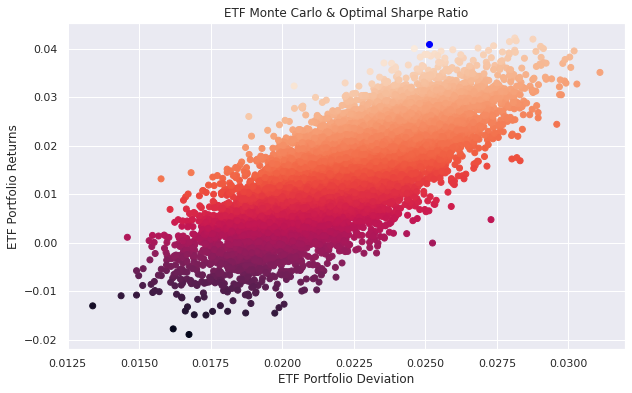

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(portfolio_deviation_etfs, portfolio_returns_etfs, c=sharpe_etf)
plt.title('ETF Monte Carlo & Optimal Sharpe Ratio')
plt.xlabel('ETF Portfolio Deviation')
plt.ylabel('ETF Portfolio Returns')
plt.scatter(max_sharpe_etf[0],max_sharpe_etf[1],c='blue')
# plt.show()
plt.savefig('ETF_SharpeRatio_montecarlo_.png')

Note that the Max Sharpe ratio is on the Efficient Frontier, indicated by a <font color='blue'><b>blue</b></font> dot on the top right corner of the scatterplot.

**General Observations:** ETFs tend to suggest that with greater risk, greater reward will come within a portfolio consisting of ETFs. Note also the Returns & Risk are generally lower to that of Stocks.

### Sharpe Ratio - Stocks

#### Code

In [ ]:
# Stock Portfolio Returns
sharpe_stocks = portfolio_returns_stocks/portfolio_deviation_stocks

In [ ]:
print('Maximum Sharpe Ratio is {:.2f}, which gives us the best risk/return combination.'.format(sharpe_stocks.max()))

Maximum Sharpe Ratio is 2.31, which gives us the best risk/return combination.


In [ ]:
print('On the other hand, minimum Sharpe Ratio is {:.2f}, which gives us the worst risk/return combination.'.format(sharpe_stocks.min()))

On the other hand, minimum Sharpe Ratio is 0.47, which gives us the worst risk/return combination.


In [ ]:
df_vol_stocks = pd.DataFrame(portfolio_std_devs_stocks)
df_means_stocks = pd.DataFrame(portfolio_exp_means_stocks)
df_sharpe_stocks = pd.DataFrame(sharpe_stocks)

In [ ]:
portfolio = pd.concat([df_vol_stocks,df_means_stocks,df_sharpe_stocks],axis=1)
portfolio.columns = ['Stocks_Volatility','Stocks_Return','Stocks_Sharpe']

Now let's find the index of the maximum & minimum sharpe ratios, which gives us the optimal and poorest values of volatility and returns within our porfolio.

In [ ]:
max_sharpe_stocks = portfolio.iloc[portfolio['Stocks_Sharpe'].idxmax()]

In [ ]:
max_sharpe_stocks

Stocks_Volatility    0.035016
Stocks_Return        0.081045
Stocks_Sharpe        2.314493
Name: 5185, dtype: float64

Now we are all set to incorporate the maximum Sharpe ratio into the risk-return plot, which provides us a scale so that we are able to evaluate portfolio performance:

In [ ]:
all_weights_stocks = np.array(all_weights_stocks)

#### Sharpe Monte Carlo Simulation

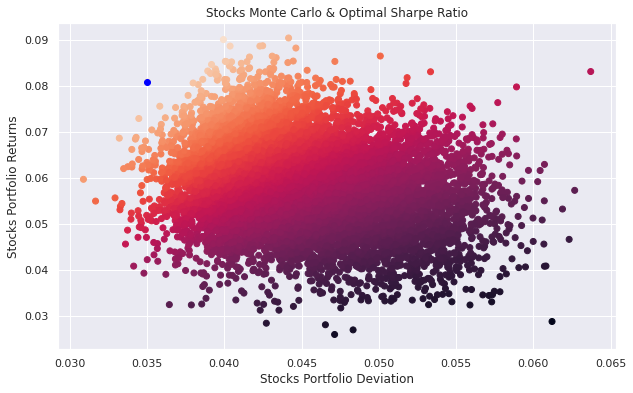

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(portfolio_deviation_stocks, portfolio_returns_stocks, c=sharpe_stocks)
plt.title('Stocks Monte Carlo & Optimal Sharpe Ratio')
plt.xlabel('Stocks Portfolio Deviation')
plt.ylabel('Stocks Portfolio Returns')
plt.scatter(max_sharpe_stocks[0],max_sharpe_stocks[1],c='blue')
# plt.show()
plt.savefig('Stocks_SharpeRatio_montecarlo_.png')

Note that the Max Sharpe ratio is on the Efficient Frontier, indicated by a <font color='blue'><b>blue</b></font> dot on the top right corner of the scatterplot.

**General Observations:**  Stocks tend to suggest that with ***lower*** risk, greater reward will come within a portfolio consisting of ETFs (interesting!). Note also the Returns & Risk are generally higher to that of ETFs.

# **Conclusions & Next Steps:** 



##Hypothesis Testing 
Answering the high level question of our project: Looking at all the time across all three disruption events (June 1, 2005 - Feb 1, 2022)
Does a statistical significant difference exist between the daily mean returns of ETFs and Stocks? 

\begin{equation}
H_0: \mu_{stock}=\mu_{ETF}\\
H_A: \mu_{stock}\neq\mu_{ETF}\\
\end{equation}

In [ ]:
from scipy.stats import ttest_ind


# Extract returns as single vector 
Stock_returns_flattend = Stock_returns.to_numpy().flatten()
Stock_returns_vector = list(Stock_returns_flattend[~np.isnan(Stock_returns_flattend)])
ETFs_returns_flattend = ETFs_returns.to_numpy().flatten()
ETFs_returns_vector = list(ETFs_returns_flattend[~np.isnan(ETFs_returns_flattend)])



#Two tailed T-Test 
test_stat, p = ttest_ind(Stock_returns_vector, ETFs_returns_vector)
print('stat=%.3f, p=%.3f' % (test_stat, p))
if p > 0.05:
  print("Fail to reject the Null hypothesis")
else:
  print("Reject the Null hypothesis")




stat=1.899, p=0.058
Fail to reject the Null hypothesis


We fall to reject the null hypothesis and must conclude that the average stock return and the average ETF return are equal. 

During periods of market disruption there is no statistically significant difference in the mean returns of Stock vs ETFs. Expanding on this idea from our exploratory data analysis, the traditional held belief that ETFs will provide a lower return at lower risk does hold true but during market disruptions they perform similarly to stocks. 

**Catigorical Differneces between the Disruption Events**

Does there exist and differences between mean stock return of the three market disruptions.
ANOVA test 

\begin{equation}
H_0: \mu_{stockCOVID}=\mu_{stockSub}=\mu_{stockSell}\\
H_A: \mu_{stockCOVID}\neq\mu_{stockSub}\neq\mu_{stockSell}\\
\end{equation}



In [ ]:
from scipy.stats import f_oneway


#Remove the mean col 
stocksSub = stocks_subprime_returns.drop('meanReturns', axis = 1)
stocksSell = stocks_selloff_returns.drop('meanReturns', axis = 1)
stocksCovid = stocks_covid_returns.drop('meanReturns',axis = 1)

# Extract returns as single vector 
#subprime
stocksSubFlattened = stocksSub.to_numpy().flatten()
stocksSubVector = list(stocksSubFlattened[~np.isnan(stocksSubFlattened)])
#selloff
stocksSellFlattened = stocksSell.to_numpy().flatten()
stocksSellVector = list(stocksSellFlattened[~np.isnan(stocksSellFlattened)])
#Covid
stocksCovidFlattened = stocksCovid.to_numpy().flatten()
stocksCovidVector = list(stocksCovidFlattened[~np.isnan(stocksCovidFlattened)])

#ANOVA test 
test_stat, p = f_oneway(stocksSubVector,stocksSellVector,stocksCovidVector)
print('stat=%.3f, p=%.3f' % (test_stat, p))
if p > 0.05:
  print("Fail to reject the Null hypothesis")
else:
  print("Reject the Null hypothesis")



stat=1.244, p=0.288
Fail to reject the Null hypothesis


Do differences exist between mean ETF return of the three market disruptions?

**ANOVA test**

\begin{equation}
H_0: \mu_{ETFCOVID}=\mu_{stockSub}=\mu_{ETFSell}\\
H_A: \mu_{ETFCOVID}\neq\mu_{ETFSub}\neq\mu_{ETFSell}\\
\end{equation}

In [ ]:
#Remove the mean col 
etfSub = ETFs_subprime_returns.drop('meanReturns', axis = 1)
etfSell = ETFs_selloff_returns.drop('meanReturns', axis = 1)
etfCovid = ETFs_covid_returns.drop('meanReturns',axis = 1)

# Extract returns as single vector 
#subprime
etfSubFlattened = etfSub.to_numpy().flatten()
etfSubVector = list(etfSubFlattened[~np.isnan(etfSubFlattened)])
#selloff
etfSellFlattened = etfSell.to_numpy().flatten()
etfSellVector = list(etfSellFlattened[~np.isnan(etfSellFlattened)])
#Covid
etfCovidFlattened = etfCovid.to_numpy().flatten()
etfCovidVector = list(etfCovidFlattened[~np.isnan(etfCovidFlattened)])


#ANOVA test 
test_stat, p = f_oneway(etfSubVector, etfSellVector, etfCovidVector)
print('stat=%.3f, p=%.3f' % (test_stat, p))
if p > 0.05:
  print("Fail to reject the Null hypothesis")
else:
  print("Reject the Null hypothesis")


stat=1.626, p=0.197
Fail to reject the Null hypothesis


While our earlier visualizations where we compared the stocks and ETF returns between the three market disruptions showed evidence that the events exhibit slight differences. With the data we collected we found no statistically significant differences between the returns for both stocks and ETFs during the three market disruptions. 

## Conclusion & Future Work

One aspect of ETFs that we have not touched on in this report is the “black box” nature of their creation. ETFs are a manufactured collection of stocks, bonds, commodities, and other tradable assets. ETF providers such as Blackrock or Vanguard, pull in a lot of profit from the sales of their ETFs. Blackrok’s iShares generated “about $2.4 billion from its share of the ETF market” [12] And ETFs are only growing more popular by the day as they provide a convenient, off the shelf package for investors to instantly diversify their portfolios. This convenience comes at a cost where the investor has to just accept that the ETF provider is calling the shots on what assets are in the ETF itself. 

Common belief is that ETFs provide lower returns but are generally a less risky investment than stocks due to their lower volatility.  Our project illustrates the fact that ETFs had higher average closing prices but appeared to have lower returns. Plotting the returns of both stocks and ETFs, we saw that ETFs had a lower amplitude.  Monte Carlo simulations and Sharpe Ratio suggest that ETFs have higher returns with higher risk; stocks had higher returns with lower risk. Note also when we tested this hypothesis, we found that, at least during periods of market disruptions, there was no difference in average returns between Stocks and ETFs.  This could be surprising at first, but illustrates how even the most resilient ETFs are not immune to wold events and disruptions. 

In the future we hope to expand this to look at more data, as the way we selected our data by only looking at the top stocks and ETFs determined by their mean trading volume potentially introduced sampling bias into our dataset. By looking at only the most popular stock, our data had stocks like Tesla and AMC, both very popular stocks in the cultural zeitgeist of 2021, and stocks that are traded by their brand name value rather than the companies actual worth. We could potentially improve the outcome of our models and tests, by looking at randomly selected stocks and ETFs from the same time periods, which could provide a more conclusive picture of the market behavior.

# Citations:

[1] W. Williams, “Timeline of US Stock Market Crashes,” Feb. 2022. [Online]. Available: https://www.investopedia.com/timeline-of-stock-market-crashes-5217820

[2] K. Voigt, “Exchange-Traded Fund (ETF),” NerdWallet, Mar. 2022. Accessed: Mar. 27, 2022. [Online]. Available: https://www.nerdwallet.com/article/investing/what-is-an-etf

[3] H. Long, “Stock market selloff: Just how bad is it?,” CNN, Feb. 04, 2016. [Online]. Available: https://money.cnn.com/2016/01/04/investing/stocks-market-dow-selloff/

[4] S. Denning, “Lest we forget: Why we had a financial crisis,” Forbes, November, vol. 22, 2011, [Online]. Available: https://www.forbes.com/sites/stevedenning/2011/11/22/5086/?sh=559b8047f92f

[5] S. Maital and E. Barzani, “The global economic impact of COVID-19: A summary of research,” Samuel Neaman Institute for National Policy Research, vol. 2020, pp. 1–12, 2020, [Online]. Available: https://www.neaman.org.il/EN/Files/Global%20Economic%20Impact%20of%20COVID-19_20200322163553.399.pdf

[6] A. P. Karasan, “Portfolio Theory and Its Application in Python,” presented at the DATA690: Data Science in Finance, UMBC, Mar. 06, 2022.

[7] M. Guidolin and M. Pedio, Essentials of applied portfolio management. EGEA spa, 2016.

[8] M. E. Mangram, “A simplified perspective of the Markowitz portfolio theory,” Global journal of business research, vol. 7, no. 1, pp. 59–70, 2013.

[9] T. W. De Amorim, J. C. S. Silva, and A. T. De Almeida Filho, “Evaluation of Index Tracking Portfolios During the COVID-19 Pandemic,” in 2021 IEEE Congress on Evolutionary Computation (CEC), 2021, pp. 1569–1576.

[10] A. Hanif, N. R. Hanun, and R. E. Febriansah, “Optimization of Stock Portfolio Using the Markowitz Model in the Era of the COVID-19 Pandemic,” TIJAB (The International Journal of Applied Business), vol. 5, no. 1, pp. 37–50, 2021.

[11] M. Buszko, W. Orzeszko, and M. Stawarz, “COVID-19 pandemic and stability of stock market—A sectoral approach,” Plos one, vol. 16, no. 5, p. e0250938, 2021.

[12] Cussen, M. P. (2020, September 12). ETF profits: What providers make from offerings. Investopedia. Retrieved March 29, 2022, from https://www.investopedia.com/news/etf-profits-how-much-money-are-providers-making/ 